## The FNO method for Parametric PDEs
- Implementation is also available in Kaggle notebook:[https://www.kaggle.com/code/yhzang32/fno4darcyflow](https://www.kaggle.com/code/yhzang32/fno4darcyflow)
- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

### (1) Generating training data 
The Darcy's equation:
\begin{equation}
\begin{split}
-\nabla\cdot(a\nabla u) &= f \\
u &= 0
\end{split}
\end{equation}
The goal of the parametric PDE problem is to learn a mapping from the PDE coefficient $a$ to the solution $u$, i.e.,:
$$
\mathcal{G}: a(x)\in\mathcal{A}\rightarrow u(x)\in\mathcal{U}
$$

In [ ]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cuda'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('DarcyFlow_train.mat', 'r')
data_test = h5py.File('DarcyFlow_test.mat', 'r')
print(data_train.keys()) 
#
def get_data(data, ndata=1000, res=29):
    # The labeled training data (a,u)
    a = np.array(data["coeff"][...,:ndata]).T
    u = np.array(data["sol"][:,:ndata]).T
    # The coordinates
    x1, x2 = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np.vstack([x1.ravel(), x2.ravel()]).T
    gridx = mesh.reshape(1, res, res, 2)
    #
    a = torch.tensor(a, dtype=dtype).reshape(ndata, res, res, -1)
    x = torch.tensor(gridx, dtype=dtype).repeat(ndata, 1, 1, 1)
    u = torch.tensor(u, dtype=dtype).reshape(ndata, res, res, -1)
    ax = torch.cat([a, x], dim=-1)
    
    return ax, u, gridx.reshape(-1,2)
ax_train, u_train, gridx = get_data(data_train)
ax_test, u_test, gridx = get_data(data_test, ndata=200)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)

####### Visualize the training data 
a_show, u_show = ax_train[0,...,0], u_train[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(a_show), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True a')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_show), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

### (2) The FNO architecture 

In [ ]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()
        '''2D Fourier layer: FFT -> linear transform -> Inverse FFT
        '''
        self.in_size = in_size 
        self.out_size = out_size 
        self.modes1 = modes1
        self.modes2 = modes2 
        #
        self.scale = 1./(in_size * out_size)
        #
        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64 
        elif (dtype==torch.float64):
            ctype = torch.complex128 
        else:
            raise TypeError(f'No such data type.')
        #
        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, 
                                                            modes1, modes2, 
                                                            dtype=ctype))
    
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        '''
        Input:
            x: size(batch_size, in_size, my_size, mx_size)
        Return:
            x: size(batch_size, out_size, my_size, mx_size)
        '''
        batch_size = x.shape[0]
        ####################### Compute Fourier coefficients up to factor of e^{-c}
        x_ft = torch.fft.rfft2(x) # size(batch_size, in_size, mx_size, my_size//2+1)
        ######################## Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1, 
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)
        ######################### Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

        return x 
        
class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int, 
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer: 
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list[1:]:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden 
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)
    
    def forward(self, ax):
        '''
        Input: 
            ax: size(batch_size, my_size, mx_size, a_size+x_size)
        Output: 
            u: size(batch_size, my_size, mx_size, out_size)
        '''
        batch_size = ax.shape[0]
        mx_size, my_size = ax.shape[1], ax.shape[2]
        # The input layer: size(b, mx_size, my_size, in_size) -> (b, hidden_size, my_size, mx_size)
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)
        # The spectral conv layer 
        hidden_last = self.hidden_list[0] 
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list[1:]):
            ax1 = conv(ax)   # size(b, hidden_size, my_size, mx_size)
            ax2 = weight(ax.view(batch_size, hidden_last, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1+ax2)
            hidden_last = hidden_size 
        # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)
#
mode1, mode2 = 8, 8
hidden_list = [40, 40, 40]
model_u = FNO2d(ax_train.shape[-1], u_train.shape[-1], mode1, mode2, hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

### (3) The loss function
$$
\theta^* = \arg\min_{\theta} \, L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \left\| \mathcal{G}_\theta(a^{(i)}(\Xi)) - u^{(i)}(\Xi) \right\|^2
$$

In [ ]:
class UnitGaussianNormalizer():

    def __init__(self, ax, eps=1e-8):
        super(UnitGaussianNormalizer, self).__init__()
        '''Apply normaliztion to the first dimension of last axis of ax
        Input:
            ax: size(N, mesh_size, 1+d)
        Output:
            mean: size(mesh_szie, 1)
            std: size(mesh_size, 1)
        '''
        self.mean = torch.mean(ax[...,0:1], 0)
        self.std = torch.std(ax[...,0:1], 0)
        self.eps = eps
    
    def encode(self, ax):
        '''
        Input:
            ax: ax: size(N, mesh_size, 1+d)
        '''
        d = ax.shape[-1] - 1
        ax_list = torch.split(ax, split_size_or_sections=[1, d], dim=-1)
        ax = torch.cat([(ax_list[0]-self.mean) / (self.std + self.eps), ax_list[1]], dim=-1)

        return ax
    
    def decode(self, ax):
        #
        d = ax.shape[-1] - 1
        ax_list = torch.split(ax, split_size_or_sections=[1, d], dim=-1)
        ax = torch.cat([ax_list[0] * (self.std + self.eps) + self.mean, ax_list[1]], dim=-1)

        return ax
#
normalizer_ax = UnitGaussianNormalizer(ax_train.to(device))
normalizer_u = UnitGaussianNormalizer(u_train.to(device))

# The loss function
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
    
    def loss_data(self, ax_batch, u_batch):
        '''loss term'''
        batch_size = u_batch.shape[0]
        ax, u = ax_batch.to(self.device), u_batch.to(self.device)
        # with normalizer
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.u_model(ax_norm)
        u_pred = normalizer_u.decode(u_pred_norm)
        # w/o normalizer
        # u_pred = self.u_model(ax)
        loss = torch.norm(u.reshape(batch_size, -1)-u_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)
        
        return loss 
    
    def get_error(self, ax, u):
        '''L2 relative error'''
        batch_size = u.shape[0]
        ax, u = ax.to(self.device), u.to(self.device)
        # with normalizer
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.u_model(ax_norm)
        u_pred = normalizer_u.decode(u_pred_norm)
        # w/o normalizer
        # u_pred = self.u_model(ax)
        error = torch.norm(u.reshape(batch_size,-1)-u_pred.reshape(batch_size,-1), 2, 1) / torch.norm(u.reshape(batch_size,-1), 2, 1)

        return torch.mean(error)

### (4) Training the model

In [ ]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, ax:torch.tensor, u:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size+x_size)
            u: size(batch_size, u_size)
        '''
        self.ax = ax
        self.u = u
    
    def __getitem__(self, index):
        return self.ax[index], self.u[index]

    def __len__(self):
        return self.ax.shape[0]

train_loader = DataLoader(MyDataset(ax_train, u_train), batch_size=50, shuffle=True)

############ Training setups
epochs = 1000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for ax_batch, u_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(ax_batch, u_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    with torch.no_grad():
        error = lossClass.get_error(ax_test, u_test)
        error_list.append(error.item())
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
        print('error_test:', error_list.pop())
print('The consuming time is:', time.time()-t0)

### (5) Performance on testing dataset
The relative error:
$$
L^2 = \sqrt{\sum_i\frac{\|u(x_i)-u_{nn}(x_i)\|^2}{\|u(x_i)\|^2}}
$$
where $u$ represents the true solution and $u_{nn}$ is the network approximation.

In [ ]:
#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred, ndata=200):
    ''' '''
    l2 = torch.norm(u.reshape(ndata,-1)-u_pred.reshape(ndata,-1), 2, 1) / torch.norm(u.reshape(ndata, -1), 2, 1)
    return l2
# with normalizer
ax_test_norm = normalizer_ax.encode(ax_test.to(device))
u_test_pred_norm = model_u(ax_test_norm)
u_test_pred = normalizer_u.decode(u_test_pred_norm).detach().cpu()
# w/o normalizer
# u_test_pred = model_u(ax_test.to(device)).detach().cpu()
print('The shape of u_pred:', u_test_pred.shape)
l2_err = L2_error(u_test, u_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
u_true, u_pred = u_test[0], u_test_pred[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True u')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(np.abs(u_true-u_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()
#############################
plt.figure()
plt.semilogy(error_list)
plt.title('error vs. epoch')
plt.show()

#  Exercise: Burger's Equation

\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is 
$$u(x,t=0)=a(x).$$

Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### Training dataset
- **a_train:** 1000 instances of $a(x)$ on $N=128$ points 
- **uT_train:** 1000 instances of $u(t=T, x)$ on $N=128$ points
- **x_train:** $N=128$ points

### Testing dataset
- **a_test:** 200 instances of $a(x)$ on $N=128$ points 
- **uT_test:** 200 instances of $u(t=T, x)$ on $N=128$ points
- **x_test:** $N=128$ points 

The shape of ax_train: torch.Size([1000, 128, 2])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridx: torch.Size([128, 1])


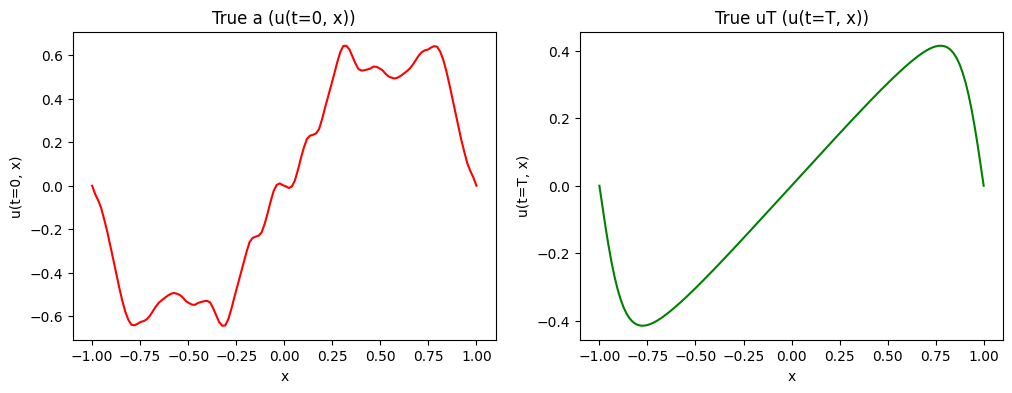

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(1234)
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('Burgers_train.mat', 'r')
#
def get_data(data, dtype):
    a = torch.tensor(np.array(data["u0"]).T, dtype=dtype)
    u = torch.tensor(np.array(data["u_sol"]).T, dtype=dtype)
    uT = u[:,-1,:]
    gridx = torch.tensor(np.array(data['x_mesh']), dtype=dtype)
    #
    uT = uT.reshape(uT.shape[0], -1, 1)
    ax = torch.cat([a.reshape(a.shape[0], -1, 1), gridx.repeat(a.shape[0], 1, 1)], dim=-1)
    
    return ax, uT, gridx
#
ax_train, uT_train, gridx = get_data(data_train, dtype)
print('The shape of ax_train:', ax_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridx:', gridx.shape)

# ####### Visualize the training data 
a_show, uT_show = ax_train[0,:,0], uT_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
axs.flat[:][0].plot(gridx.flatten(), a_show.flatten(), color='r')
axs.flat[:][0].set_title('True a (u(t=0, x))')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('u(t=0, x)')
#
axs.flat[:][1].plot(gridx.flatten(), uT_show.flatten(), color='green')
axs.flat[:][1].set_title('True uT (u(t=T, x))')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('u(t=T, x)')
#
plt.show()